# 04_eval.ipynb: Model Evaluation, Prediction, and Figure Generation

**Purpose:**  
This notebook evaluates the best pipeline from the experiment grid on a held-out test set, generates predictions, and produces key report figures (confusion matrix, metrics table).  
All steps are reproducible and self-contained, requiring only your cleaned data and configuration files.


In [1]:
# 1. Import Required Libraries

import sys
from pathlib import Path

# Add project root to path for src imports
sys.path.insert(0, str(Path().resolve().parent))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

from src.preprocess import build_pipeline
from src.models import svm   # Use your best model from grid


In [2]:
# 2. Load Cleaned Data and Prepare Train/Test Split

# Load the cleaned tweets produced by your EDA script.  
# Split data into train and test sets (80/20), preserving class balance.
# Load cleaned data
df = pd.read_feather("../data/tweets.feather")
X = df['text']
y = df['label_name']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Train samples: 5153, Test samples: 1289


In [3]:
## 3. Build, Train, and Predict with Best Pipeline

# Rebuild the pipeline with the best configuration (as found in results).  
# Fit on train data, predict on the test set.

# Build pipeline from config (example: word-level TF-IDF + SVM)
pipe = build_pipeline("../conf/rep_word_tfidf.yaml")
pipe.steps.append(("clf", svm()))

# Fit pipeline and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


In [4]:
## 4. Save Test Predictions for Reproducibility

# (Optional) Save predictions and true labels for transparency and future analysis

pred_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})
pred_df.to_csv("../reports/best_model_predictions.csv", index=False)
print("Test predictions saved to ../reports/best_model_predictions.csv")


Test predictions saved to ../reports/best_model_predictions.csv


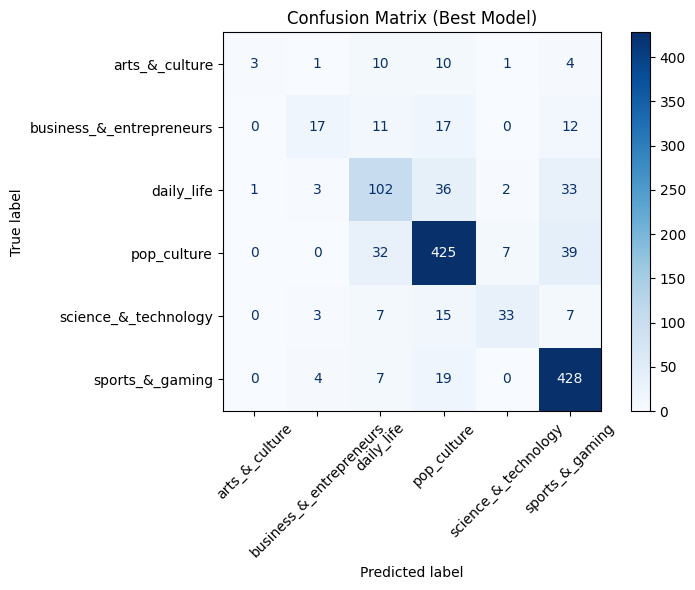

                          precision    recall  f1-score   support

          arts_&_culture      0.750     0.103     0.182        29
business_&_entrepreneurs      0.607     0.298     0.400        57
              daily_life      0.604     0.576     0.590       177
             pop_culture      0.814     0.845     0.829       503
    science_&_technology      0.767     0.508     0.611        65
         sports_&_gaming      0.818     0.934     0.873       458

                accuracy                          0.782      1289
               macro avg      0.727     0.544     0.581      1289
            weighted avg      0.774     0.782     0.767      1289



In [5]:
## 5. Evaluate Model: Confusion Matrix and Classification Report

# Generate and save the confusion matrix figure for your report.  
# Print detailed precision, recall, and F1 metrics per class.

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Best Model)")
plt.tight_layout()
plt.savefig("../reports/figures/cm_best.png")
plt.show()

# Print classification metrics
report = classification_report(y_test, y_pred, target_names=labels, digits=3)
print(report)


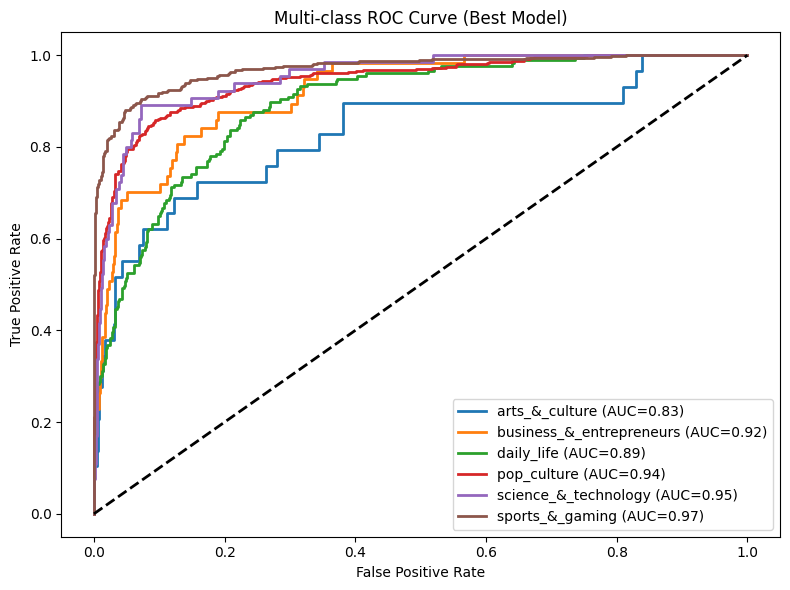

In [6]:
# 6. Plot and Save ROC Curves (One-vs-Rest, Multi-class)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Prepare for multi-class ROC
n_classes = len(labels)
y_test_bin = label_binarize(y_test, classes=labels)

# Check if pipeline supports probability output (for ROC curves)
try:
    y_score = pipe.predict_proba(X_test)
except AttributeError:
    try:
        y_score = pipe.decision_function(X_test)
    except Exception as e:
        print("Pipeline does not support probability or decision function output for ROC curve.")
        y_score = None

if y_score is not None:
    plt.figure(figsize=(8,6))
    for i, class_name in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC={roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve (Best Model)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../reports/figures/roc_best.png")
    plt.show()
else:
    print("ROC curve cannot be generated for this pipeline/model (no probability or decision function available).")


In [7]:
# 7. Load and Display Aggregated Experiment Results

# Show Macro-F1, accuracy, and other metrics for all model/config combinations.
results_path = "../reports/results_table2.csv"
results = pd.read_csv(results_path)
print("Summary of Experiment Grid Results:")
display(results)


Summary of Experiment Grid Results:


,Pipeline,Macro-F1,±SD,Report File
0,tfidf+svm_rep_word,0.5868,0.0194,cv_svm_rep_word_tfidf.txt
1,chargram+svm_rep,0.5868,0.0194,cv_svm_rep_chargram.txt
2,glove+svm_rep,0.5868,0.0194,cv_svm_rep_glove.txt
3,chargram+lr_rep,0.3978,0.0148,cv_lr_rep_chargram.txt
4,glove+lr_rep,0.3978,0.0148,cv_lr_rep_glove.txt
5,tfidf+lr_rep_word,0.3978,0.0148,cv_lr_rep_word_tfidf.txt
6,tfidf+rf_rep_word,0.3866,0.0185,cv_rf_rep_word_tfidf.txt
7,chargram+rf_rep,0.3854,0.0118,cv_rf_rep_chargram.txt
8,glove+rf_rep,0.3849,0.0146,cv_rf_rep_glove.txt
9,chargram+mnb_rep,0.2813,0.0033,cv_mnb_rep_chargram.txt
